In [6]:
import os
import pandas as pd
import re
import itertools
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../others')
import venn

def barcode_type(barcode):
    # example: get "01" from TCGA-W5-A22X-01A
    # 00-09 tumor; 10-19 normal; 20-29 control
    match = re.search(r'-([0-2][0-9])[A-Z]*', barcode)
    if match:
        code = int(match.group(1))
        if code < 10:
            return "TUMOR"
        elif code < 20:
            return "NORMAL"
        elif code < 30:
            return "CONTROL"
        else:
            raise SyntaxError("Its not a TCGA barcode format.")

def sample_type(sample_ID):
    if sample_ID[-1] == "N":
        return "NORMAL"
    elif sample_ID[-1] == "T":
        return "TUMOR"
    else:
        raise SyntaxError("Wrong sample ID format.")
def open_vcf(vcf_file):
    # Find the line number containing string "#CHROM"
    with open(vcf_file, 'r') as f:
        for line_ind, line in enumerate(f):
            if line.startswith('#CHROM'):
                break
    
    # load data and skip headers
    df = pd.read_csv(vcf_file, sep='\t', header=line_ind, dtype=object)
    return df

def parse_info(format, info_str):
    '''
    GT: 基因型 (Genotype)
    DP: 深度 (Depth)
    AD: 等位基因深度 (Allelic Depth)，通常是指各等位基因的深度
    BQ: 鹼基品質 (Base Quality)
    AF = FREQ: Allele Frequency(等位基因頻率) = AD/DP
    RD: Reference Depth(参考序列深度)
    
    varscan, GT:GQ:DP:RD:AD:FREQ:DP4, 0/0:.:68:65:2:2.99%:15,50,1,1
    mutect2, GT:AD:AF:DP:F1R2:F2R1, 0/1:12,4:0.275:16:8,2:4,2
    mutect2, GT:AD:AF:DP:F1R2:F2R1, 0/1/2:13,3,2:0.181,0.145:18:3,1,1:10,2,1
    muse, GT:DP:AD:BQ:SS, 0/1:19:14,5:31,31:2
    pindel, GT:AD, 0/0:20,0, 0/0:19,1

    * mutect 2 multiallelic問題已經在前處理中使用bcftools norm拆分 *
    '''
    info_list = info_str.split(":")
    # varscan format
    if format == "GT:GQ:DP:RD:AD:FREQ:DP4":
        DP_index, AD_index, AF_index = 2, 4, 5
        DP, AD = int(info_list[DP_index]), int(info_list[AD_index])
        AF = float(info_list[AF_index].replace("%", ""))/100
        
    # mutect2 format
    elif format == "GT:AD:AF:DP:F1R2:F2R1" or format == "GT:AD:AF:DP:F1R2:F2R1:PGT:PID:PS" \
        or format == 'GT:AD:AF:DP:F1R2:F2R1:FAD:SB' or format == 'GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB':
        DP_index, AD_index, AF_index = 3, 1, 2
        AD = int(info_list[AD_index].split(",")[1])
        DP, AF = int(info_list[DP_index]), float(info_list[AF_index])
        
    # muse format
    elif format == "GT:DP:AD:BQ:SS":
        DP_index, AD_index = 1, 2
        AD = int(info_list[AD_index].split(",")[1])
        DP = int(info_list[DP_index])
        AF = AD / DP if DP > 0 else 0

    # pindel format
    elif format == "GT:AD":
        AD_index = 1
        D1, D2 = info_list[AD_index].split(",")
        D1, D2 = int(D1), int(D2) 
        DP = D1 + D2
        AD = D2
        AF = AD / DP if DP > 0 else 0

    else:
        raise ValueError(f"{format} is an Unexpected format")
    return DP, AD, AF

def preprocess_vcf(vcf_file):
    vcf_df = open_vcf(vcf_file)
    vcf_df = vcf_df.loc[vcf_df.FILTER == "PASS"] # keep "PASS"
    
    # keep only chr1-22 or XY
    vcf_df = vcf_df[vcf_df['#CHROM'].str.contains(r'^chr(?:[1-9]|1\d|2[0-2]|X|Y)$')]
    
    # make sure TUMOR/NORMAL is upper
    vcf_df.columns = ['CHROM'] + list(vcf_df.columns[1:].str.upper()) 
    
    # reindex to CHROM|POS|REF|ALT and drop 7 columns
    vcf_df.index = vcf_df.loc[:, ["CHROM", "POS", "REF", "ALT"]].apply(lambda row: "|".join(row.astype(str)), axis=1)
    vcf_df = vcf_df.drop(columns=["CHROM", "POS", "REF", "ALT", 'ID', 'QUAL', 'FILTER'])
    
    # if no columns TUMOR/NORMAL(mutect2) rename last 2 columns
    if "TUMOR" not in vcf_df.columns or "NORMAL" not in vcf_df.columns :
        vcf_df = vcf_df.rename(columns={vcf_df.columns[-1]: sample_type(vcf_df.columns[-1]), 
                                        vcf_df.columns[-2]: sample_type(vcf_df.columns[-2])})
    # extract DP AD AF columns from TUMOR columns
    vcf_df[['DP', 'AD', 'AF']] = vcf_df.apply(lambda row: parse_info(row['FORMAT'], row['TUMOR']), axis=1, result_type='expand')
    
    return vcf_df

def vcf_df_filter(vcf_df, DP=30, AD=3, AF=0.05):
    filter = (vcf_df.DP >= DP) & (vcf_df.DP >= AD) & (vcf_df.AF > AF)
    return vcf_df[filter]

def split_single_sample(case_df):
    splited_info = case_df.drop(["case"], axis=1).copy().reset_index()
    splited_info[["#CHROM", "POS", "REF", "ALT"]] = splited_info['index'].str.split('|', expand=True)#.values
    splited_info = splited_info.drop('index', axis=1)
    splited_info = splited_info.loc[:, list(splited_info.columns[-4:]) + list(splited_info.columns[:-4])]
    return splited_info

def split_all_case_df(all_case_df):
    splited_info = all_case_df.reset_index()['index'].str.split("|", expand=True)
    splited_info.columns = ["#CHROM", "POS", "REF",  "ALT"]
    splited_info['callers'] = all_case_df_2_callers.apply(lambda row: ';'.join([caller for caller, value in row[caller_list].items() if value]), axis=1).values
    splited_info['case'] = all_case_df_2_callers['case'].values
    sorter = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']
    splited_info['#CHROM'] = splited_info['#CHROM'].astype('category')
    splited_info['#CHROM'] = splited_info['#CHROM'].cat.set_categories(sorter)
    splited_info = splited_info.sort_values(by=['#CHROM', 'POS'])
    splited_info = splited_info.reset_index(drop=True)   
    return splited_info

TCGA-W5-AA2X


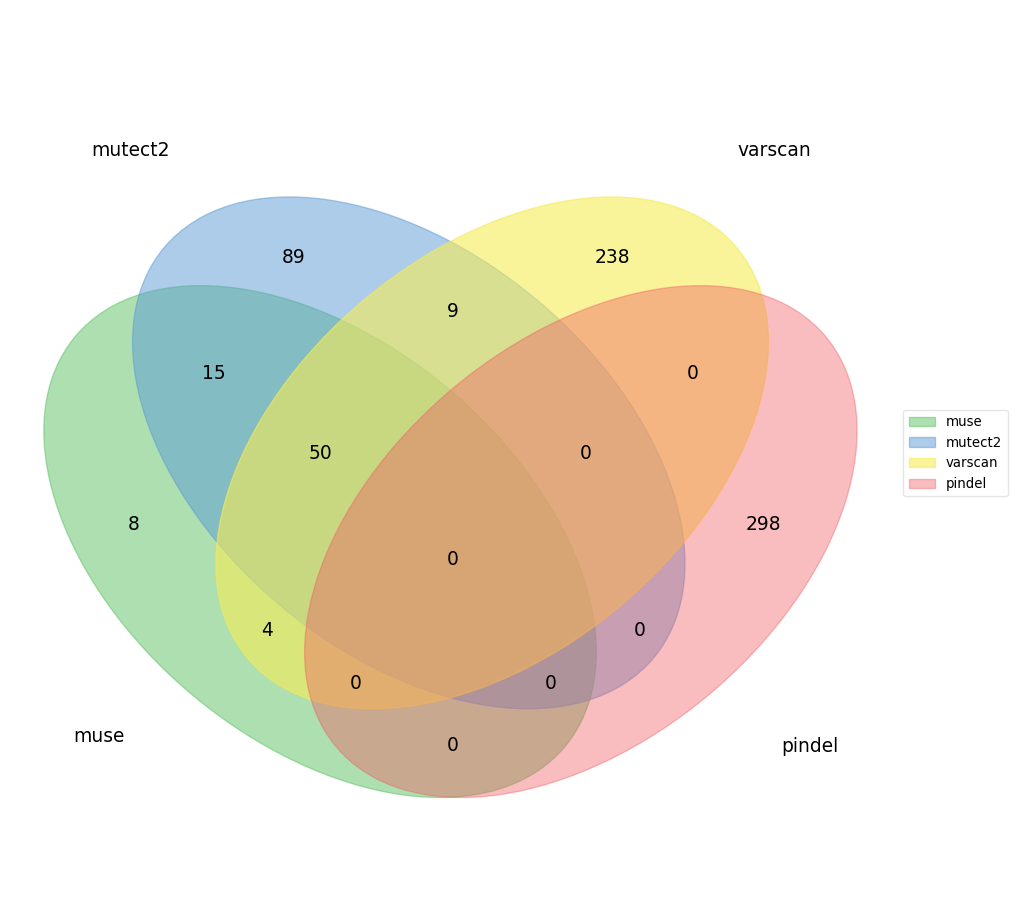

In [7]:
pd.set_option('future.no_silent_downcasting', True)
project_dir = "/home/data/dataset/CHOL_2sample_new"
os.chdir(project_dir)
os.makedirs("variants_calling/merged_vcf", exist_ok=True)

case_IDs = pd.read_csv("case_IDs.tsv", sep="\t", header=None)[0].tolist()
all_case_df = pd.DataFrame()
caller_list = ["muse", "mutect2", "varscan", "pindel"]
case_IDs
#unique_case_IDs = sample_sheet.loc[:, "Case ID"].unique()


caller_stat_df = pd.DataFrame(columns=["all"] 
                                    + [f"{caller}_raw" for caller in caller_list]
                                    + [f"{caller}_filtered" for caller in caller_list]
                                    + ["2_caller"],
                              index=pd.Index(case_IDs, name="case_ID"))

for case_ID in case_IDs: # ["TCGA-W5-AA2R"]:##
    print(case_ID)
    result_dict = {
        "muse": preprocess_vcf(vcf_file=f"variants_calling/muse/{case_ID}.MuSE.vcf"),
        "mutect2": preprocess_vcf(vcf_file=f"variants_calling/mutect/{case_ID}.splited.vcf"),
        "varscan": pd.concat([
            preprocess_vcf(vcf_file=f"variants_calling/varscan/{case_ID}.varscan.indel.Somatic.hc.vcf"),
            preprocess_vcf(vcf_file=f"variants_calling/varscan/{case_ID}.varscan.snp.Somatic.hc.vcf")]),
        "pindel": preprocess_vcf(vcf_file=f"variants_calling/pindel/{case_ID}.indel.filtered.vcf")
    }
    # filter DP, AD, AF then merge all caller -> case_df
    case_df = pd.DataFrame()
    for package_name, caller_df in result_dict.items():
        caller_stat_df.loc[case_ID, f"{package_name}_raw"] = len(caller_df)
        filtered_df = vcf_df_filter(caller_df)
        caller_stat_df.loc[case_ID, f"{package_name}_filtered"] = len(filtered_df)
        filtered_df = pd.DataFrame(True, index=filtered_df.index, columns=[package_name])
        case_df = pd.concat([case_df, filtered_df], axis=1)
        
    case_df = case_df.fillna(False).infer_objects(copy=False)

    # filter at least 2 caller hit
    caller_2hit_filter = case_df.loc[:, caller_list].sum(axis=1) >= 2
    caller_stat_df.loc[case_ID, "all"] = len(case_df)
    caller_stat_df.loc[case_ID, "2_caller"] = caller_2hit_filter.sum()
    case_df["case"] = case_ID
    splited_case_df = split_single_sample(case_df)
    splited_case_df.to_csv(f"variants_calling/merged_vcf/{case_ID}.vcf", sep="\t", index=False)
    all_case_df = pd.concat([all_case_df, case_df])

# all_case_df
all_case_df_gb = all_case_df.groupby(all_case_df.index)
all_case_df.groupby("case").size()

# merge same ID
all_case_df_dedup = all_case_df_gb.agg({'muse':'max',
                                          'mutect2':'max',
                                          'varscan':'max',
                                          'pindel':'max',
                                          'case': lambda x: ','.join(x)})
callers_2_hit = all_case_df_dedup.loc[:, caller_list].sum(axis=1) >= 2
all_case_df_2_callers = all_case_df_dedup[callers_2_hit] 
splited_info = all_case_df_2_callers.reset_index()['index'].str.split("|", expand=True)
splited_info.columns = ["#CHROM", "POS", "REF",  "ALT"]
splited_info['callers'] = all_case_df_2_callers.apply(lambda row: ';'.join([caller for caller, value in row[caller_list].items() if value]), axis=1).values
splited_info['case'] = all_case_df_2_callers['case'].values

sorter = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']
splited_info['#CHROM'] = splited_info['#CHROM'].astype('category')
splited_info['#CHROM'] = splited_info['#CHROM'].cat.set_categories(sorter)
splited_info = splited_info.sort_values(by=['#CHROM', 'POS'])
splited_info = splited_info.reset_index(drop=True)   

# save files
splited_info.to_csv("variants_calling/all_samples_2callers.vcf", sep="\t", index=False)
caller_stat_df.to_csv("variants_calling/caller_stat_df.csv")

labels = venn.get_labels(all_case_df.loc[:, caller_list])
fig, ax = venn.venn4(labels, names=caller_list)
fig.savefig("variants_calling/venn.png")